<a href="https://colab.research.google.com/github/alimohammadi44/Financial-Fraud-Detection/blob/main/notebooks/kaggle_Credit_Card_Fraud_Detection_Predictive_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center><font size="6">Credit Card Fraud Detection Predictive Models</font></center></h1>


<center><img src="https://images.unsplash.com/photo-1563013544-824ae1b704d3?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1050&q=80" width="600"></img></center>


# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Load packages</a>  
- <a href='#3'>Read the data</a>  
- <a href='#4'>Check the data</a>  
    - <a href='#41'>Glimpse the data</a>  
    - <a href='#42'>Check missing data</a>
    - <a href='#43'>Check data unbalance</a>
- <a href='#5'>Data exploration</a>
- <a href='#6'>Predictive models</a>  
    - <a href='#61'>RandomForrestClassifier</a>
    - <a href='#62'>AdaBoostClassifier</a>     
    - <a href='#63'>CatBoostClassifier</a>
    - <a href='#64'>XGBoost</a>
    - <a href='#65'>LightGBM</a>
- <a href='#7'>Conclusions</a>
- <a href='#8'>References</a>


# <a id="1">Introduction</a>  

The datasets contains transactions made by credit cards in **September 2013** by european cardholders. This dataset presents transactions that occurred in two days, where we have **492 frauds** out of **284,807 transactions**. The dataset is **highly unbalanced**, the **positive class (frauds)** account for **0.172%** of all transactions.  

It contains only numerical input variables which are the result of a **PCA transformation**.   

Due to confidentiality issues, there are not provided the original features and more background information about the data.  

* Features **V1**, **V2**, ... **V28** are the **principal components** obtained with **PCA**;  
* The only features which have not been transformed with PCA are **Time** and **Amount**. Feature **Time** contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature **Amount** is the transaction Amount, this feature can be used for example-dependant cost-senstive learning.   
* Feature **Class** is the response variable and it takes value **1** in case of fraud and **0** otherwise.  



# <a id="2">Load packages</a>

In [70]:
pip install CatBoost

In [71]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

# IS_LOCAL = False

# import os


# <a id="3">Read the data</a>

In [72]:
# data_df = pd.read_csv(PATH+"/creditcard.csv")
data_df = pd.read_csv("creditcard0.csv")

# <a id="4">Check the data</a>

In [73]:
print("Credit Card Fraud Detection data -  rows:",data_df.shape[0]," columns:", data_df.shape[1])

Credit Card Fraud Detection data -  rows: 284807  columns: 31


## <a id="41">Glimpse the data</a>

We start by looking to the data features (first 5 rows).

In [74]:
data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Let's look into more details to the data.

In [75]:
data_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Looking to the **Time** feature, we can confirm that the data contains **284,807** transactions, during 2 consecutive days (or **172792** seconds).

## <a id="42">Check missing data</a>  

Let's check if there is any missing data.

In [76]:
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There is no missing data in the entire dataset.

## <a id="43">Data unbalance</a>

Let's check data unbalance with respect with *target* value, i.e. **Class**.

In [77]:
import plotly.io as pio
pio.renderers.default = 'colab'   # or 'notebook_connected' on Kaggle

In [78]:
temp = data_df["Class"].value_counts()
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'Class', showticklabels=True),
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

Only **492** (or **0.172%**) of transaction are fraudulent. That means the data is highly unbalanced with respect with target variable **Class**.

# <a id="5">Data exploration</a>

## Transactions in time

In [79]:
class_0 = data_df.loc[data_df['Class'] == 0]["Time"]
class_1 = data_df.loc[data_df['Class'] == 1]["Time"]

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

Fraudulent transactions have a distribution more even than valid transactions - are equaly distributed in time, including the low real transaction times, during night in Europe timezone.

Let's look into more details to the time distribution of both classes transaction, as well as to aggregated values of transaction count and amount, per hour. We assume (based on observation of the time distribution of transactions) that the time unit is second.

In [80]:
data_df['Hour'] = data_df['Time'].apply(lambda x: np.floor(x / 3600))

tmp = data_df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


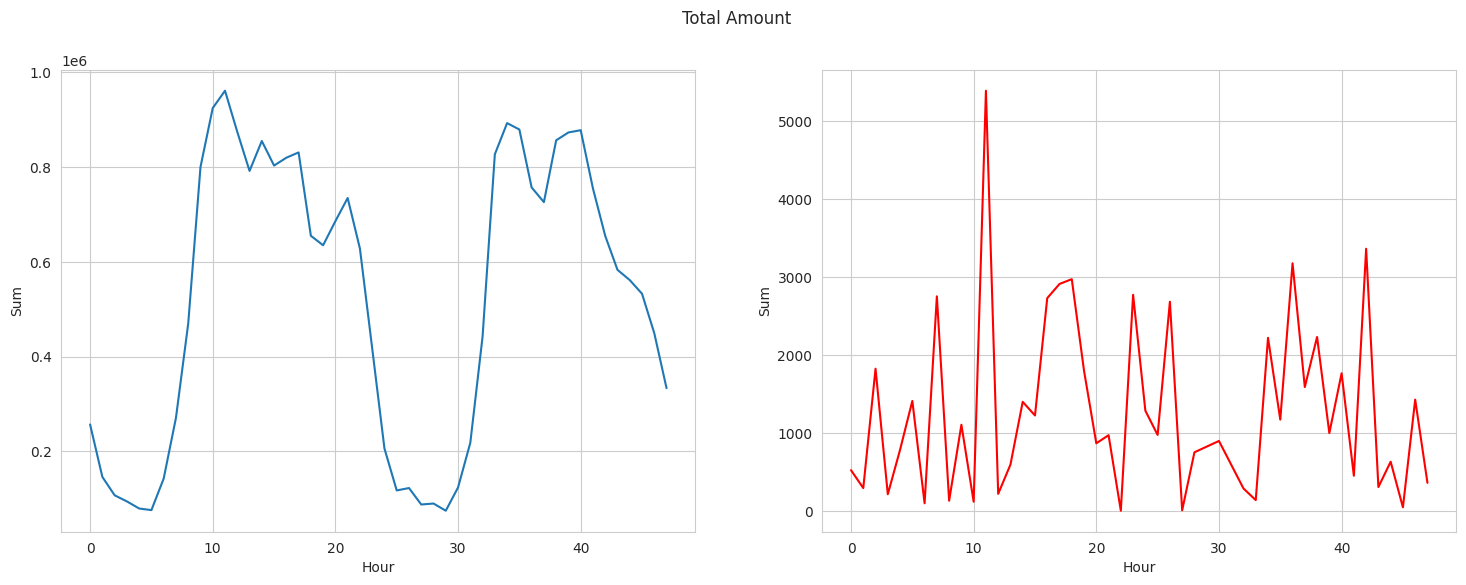

In [81]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Amount")
plt.show();

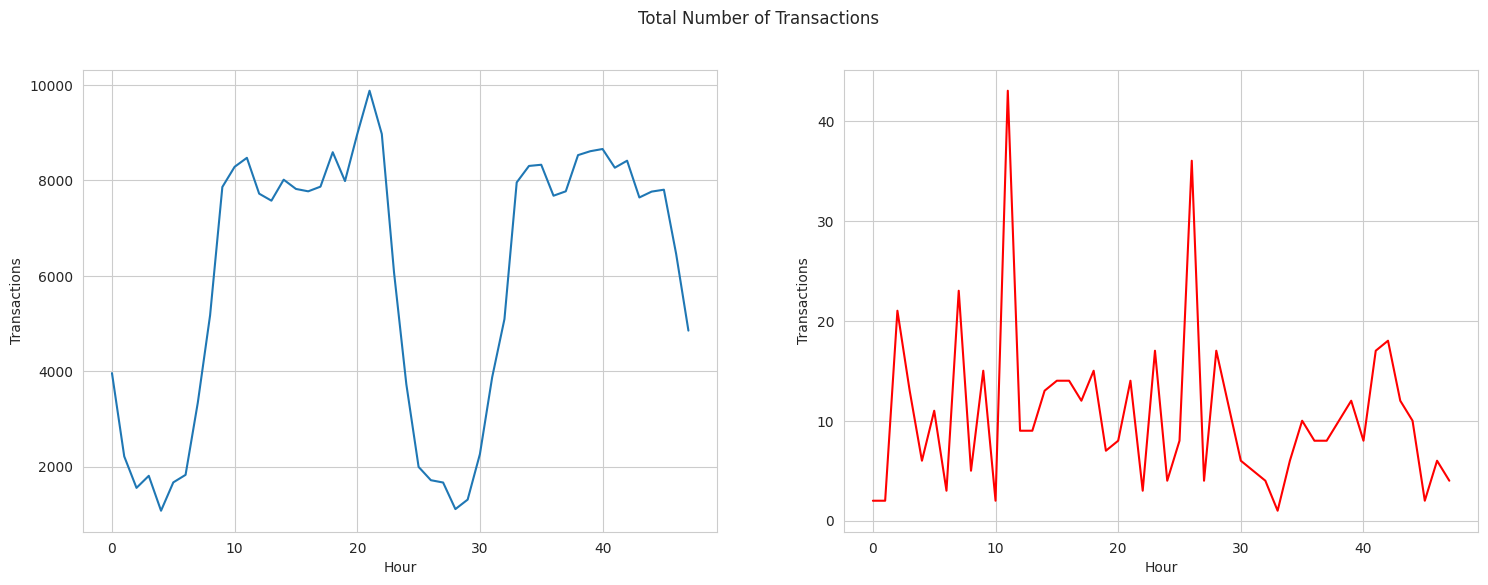

In [82]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Number of Transactions")
plt.show();

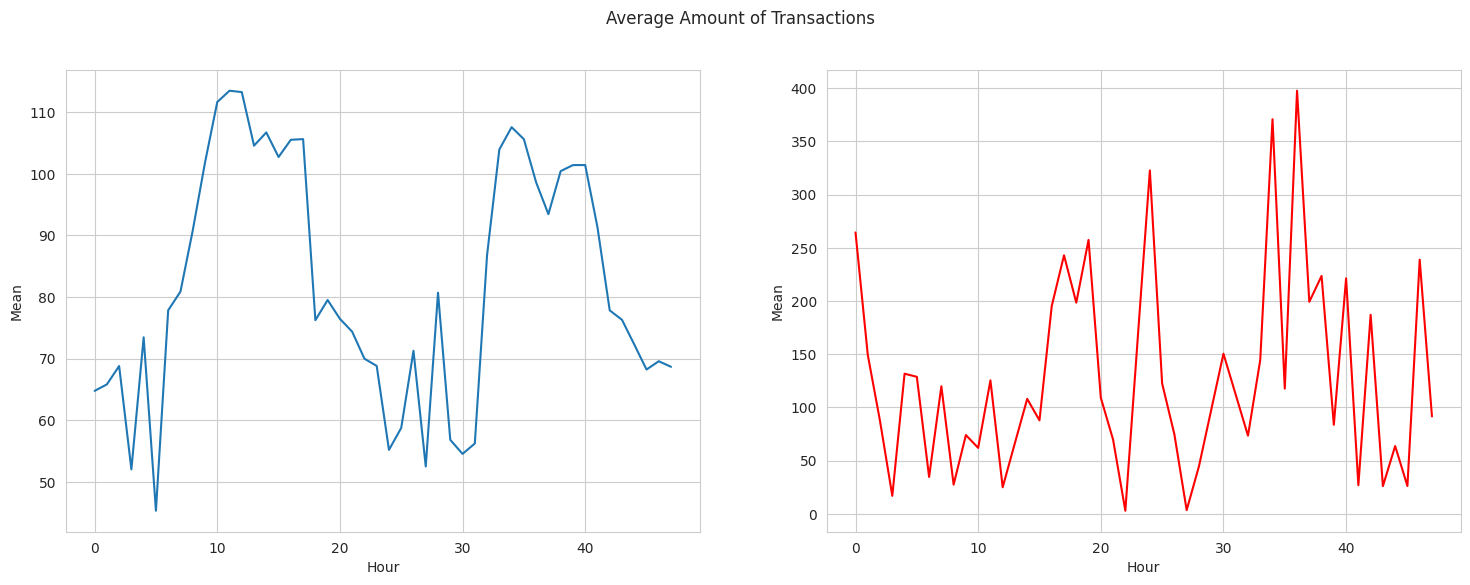

In [83]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="red")
plt.suptitle("Average Amount of Transactions")
plt.show();

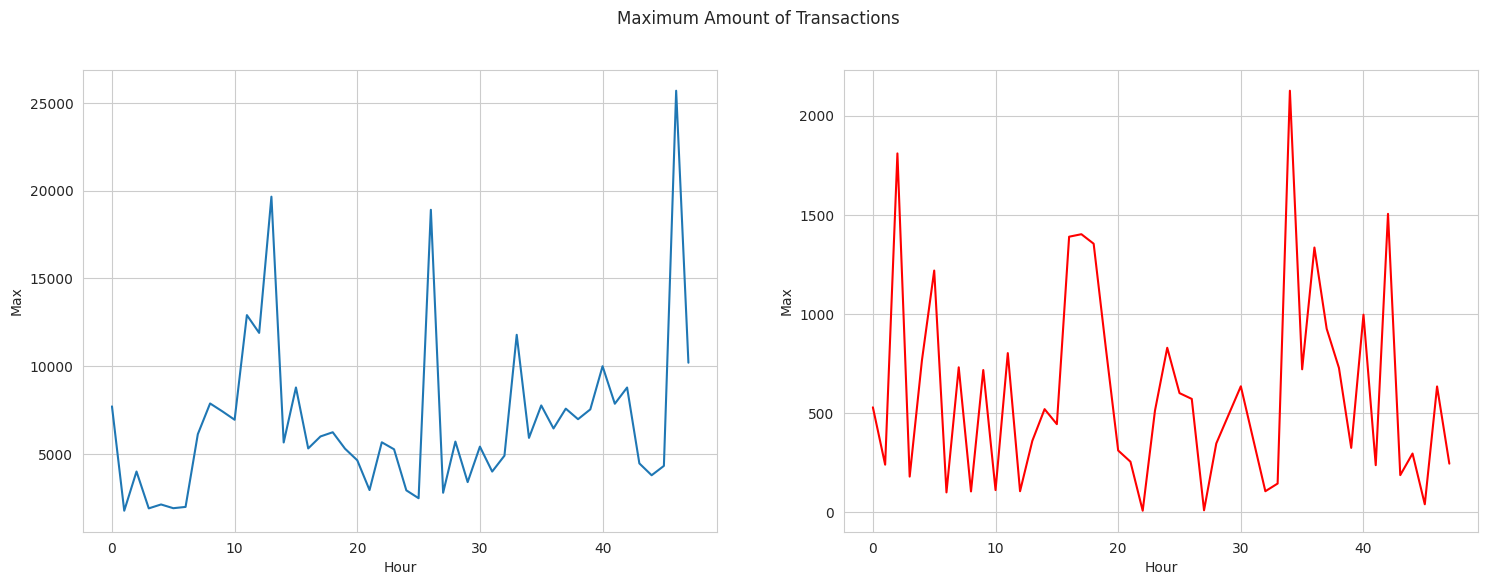

In [84]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df.loc[df.Class==1], color="red")
plt.suptitle("Maximum Amount of Transactions")
plt.show();

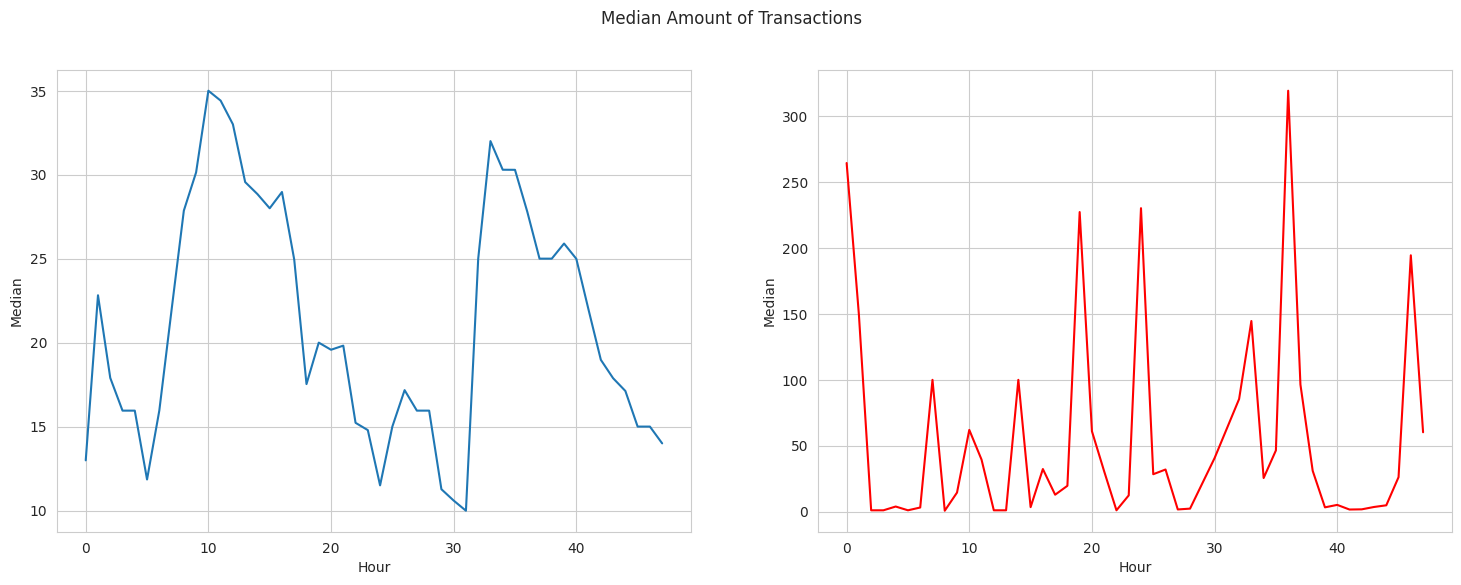

In [85]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Median", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Median", data=df.loc[df.Class==1], color="red")
plt.suptitle("Median Amount of Transactions")
plt.show();

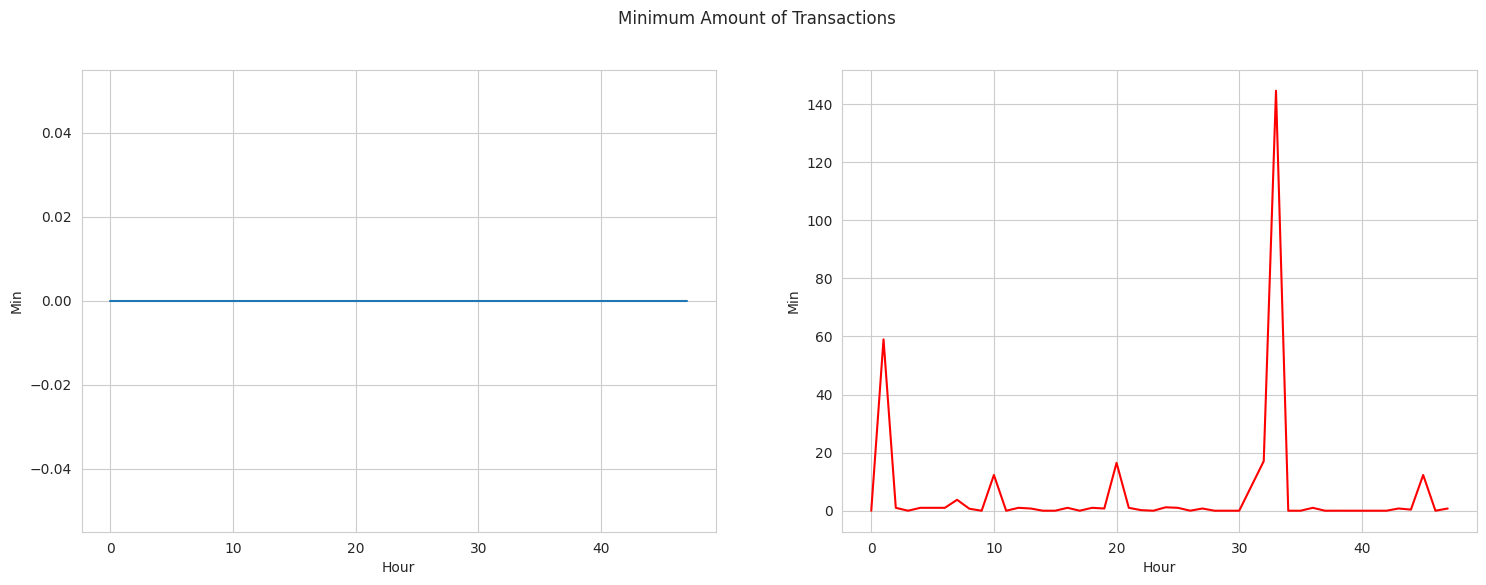

In [86]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=df.loc[df.Class==1], color="red")
plt.suptitle("Minimum Amount of Transactions")
plt.show();

## Transactions amount

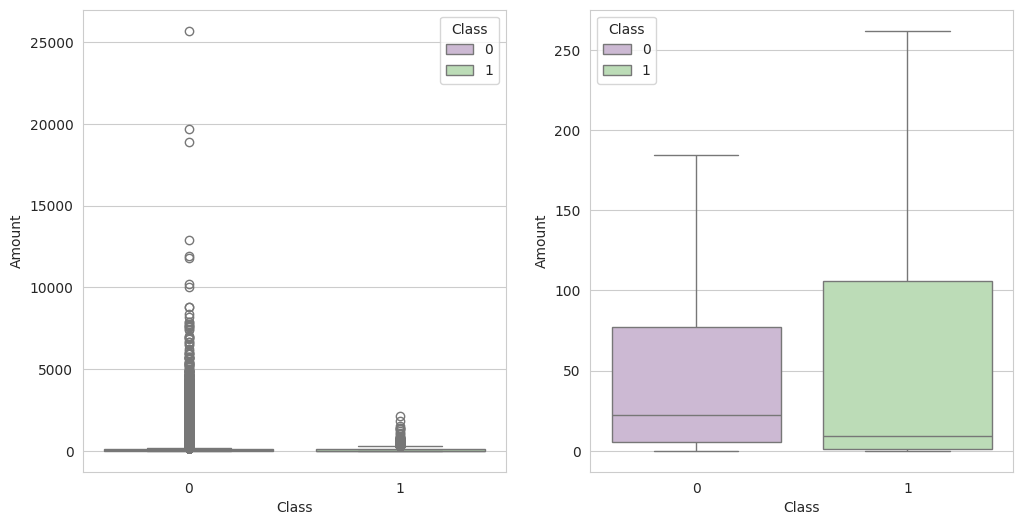

In [87]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=False)
plt.show();

In [88]:
tmp = data_df[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe()

,Amount
count,284315.000000
mean,88.291022
std,250.105092
min,0.000000
25%,5.650000
50%,22.000000
75%,77.050000
max,25691.160000


In [89]:
class_1.describe()

,Amount
count,492.000000
mean,122.211321
std,256.683288
min,0.000000
25%,1.000000
50%,9.250000
75%,105.890000
max,2125.870000


The real transaction have a larger mean value, larger Q1, smaller Q3 and Q4 and larger outliers; fraudulent transactions have a smaller Q1 and mean, larger Q4 and smaller outliers.

Let's plot the fraudulent transactions (amount) against time. The time is shown is seconds from the start of the time period (totaly 48h, over 2 days).

In [90]:
fraud = data_df.loc[data_df['Class'] == 1]

trace = go.Scatter(
    x = fraud['Time'],y = fraud['Amount'],
    name="Amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['Amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Amount of fraudulent transactions',
          xaxis = dict(title = 'Time [s]', showticklabels=True),
          yaxis = dict(title = 'Amount'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')

## Features correlation

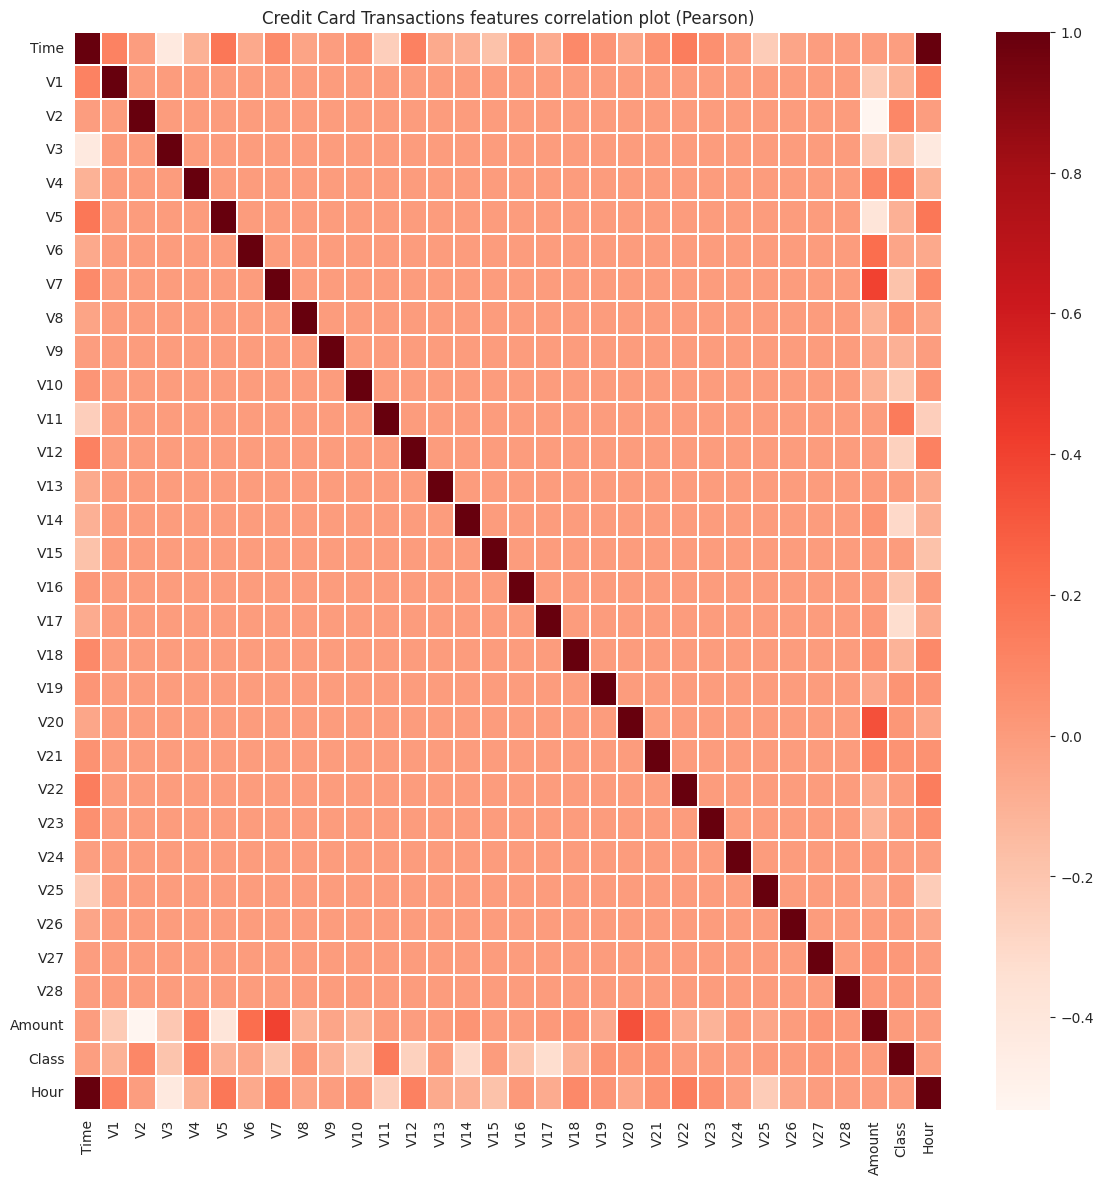

In [91]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

As expected, there is no notable correlation between features **V1**-**V28**. There are certain correlations between some of these features and **Time** (inverse correlation with **V3**) and **Amount** (direct correlation with **V7** and **V20**, inverse correlation with **V1** and **V5**).


Let's plot the correlated and inverse correlated values on the same graph.

Let's start with the direct correlated values: {V20;Amount} and {V7;Amount}.

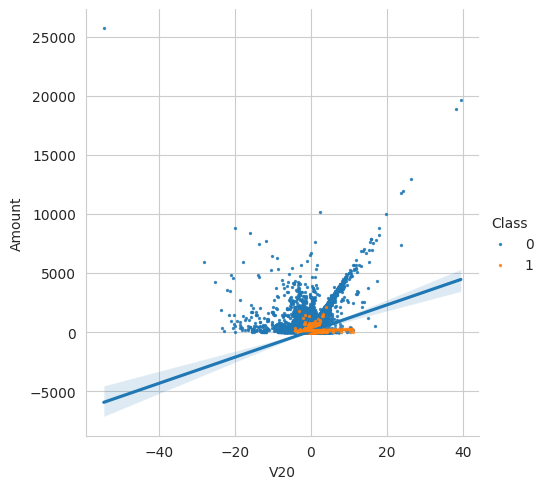

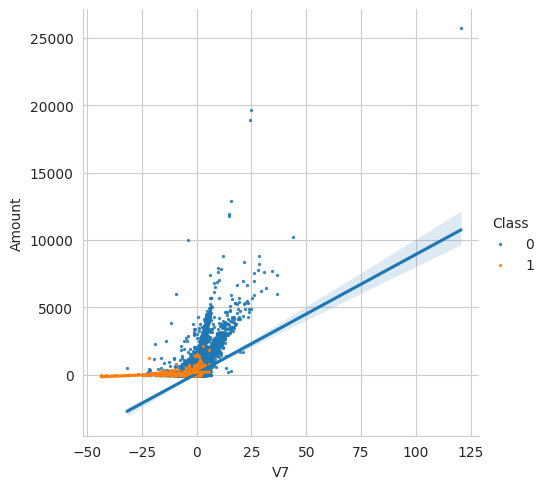

In [92]:
s = sns.lmplot(x='V20', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

We can confirm that the two couples of features are correlated (the regression lines for **Class = 0** have a positive slope, whilst the regression line for **Class = 1** have a smaller positive slope).

Let's plot now the inverse correlated values.

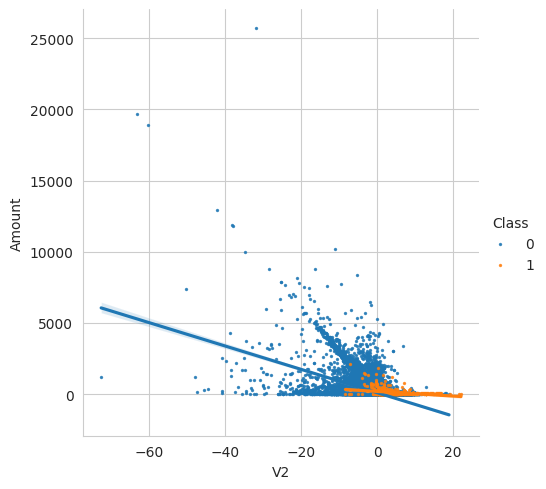

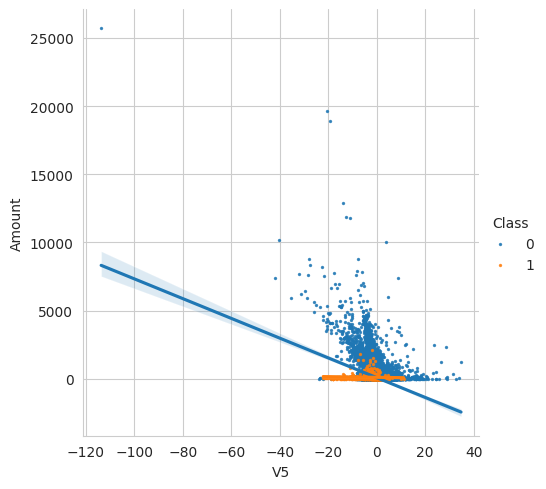

In [93]:
s = sns.lmplot(x='V2', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

We can confirm that the two couples of features are inverse correlated (the regression lines for **Class = 0** have a negative slope while the regression lines for **Class = 1** have a very small negative slope).


## Features density plot

/tmp/ipython-input-955923673.py:14: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/tmp/ipython-input-955923673.py:15: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/tmp/ipython-input-955923673.py:14: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/tmp/ipython-input-955923673.py:15: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameter

<Figure size 640x480 with 0 Axes>

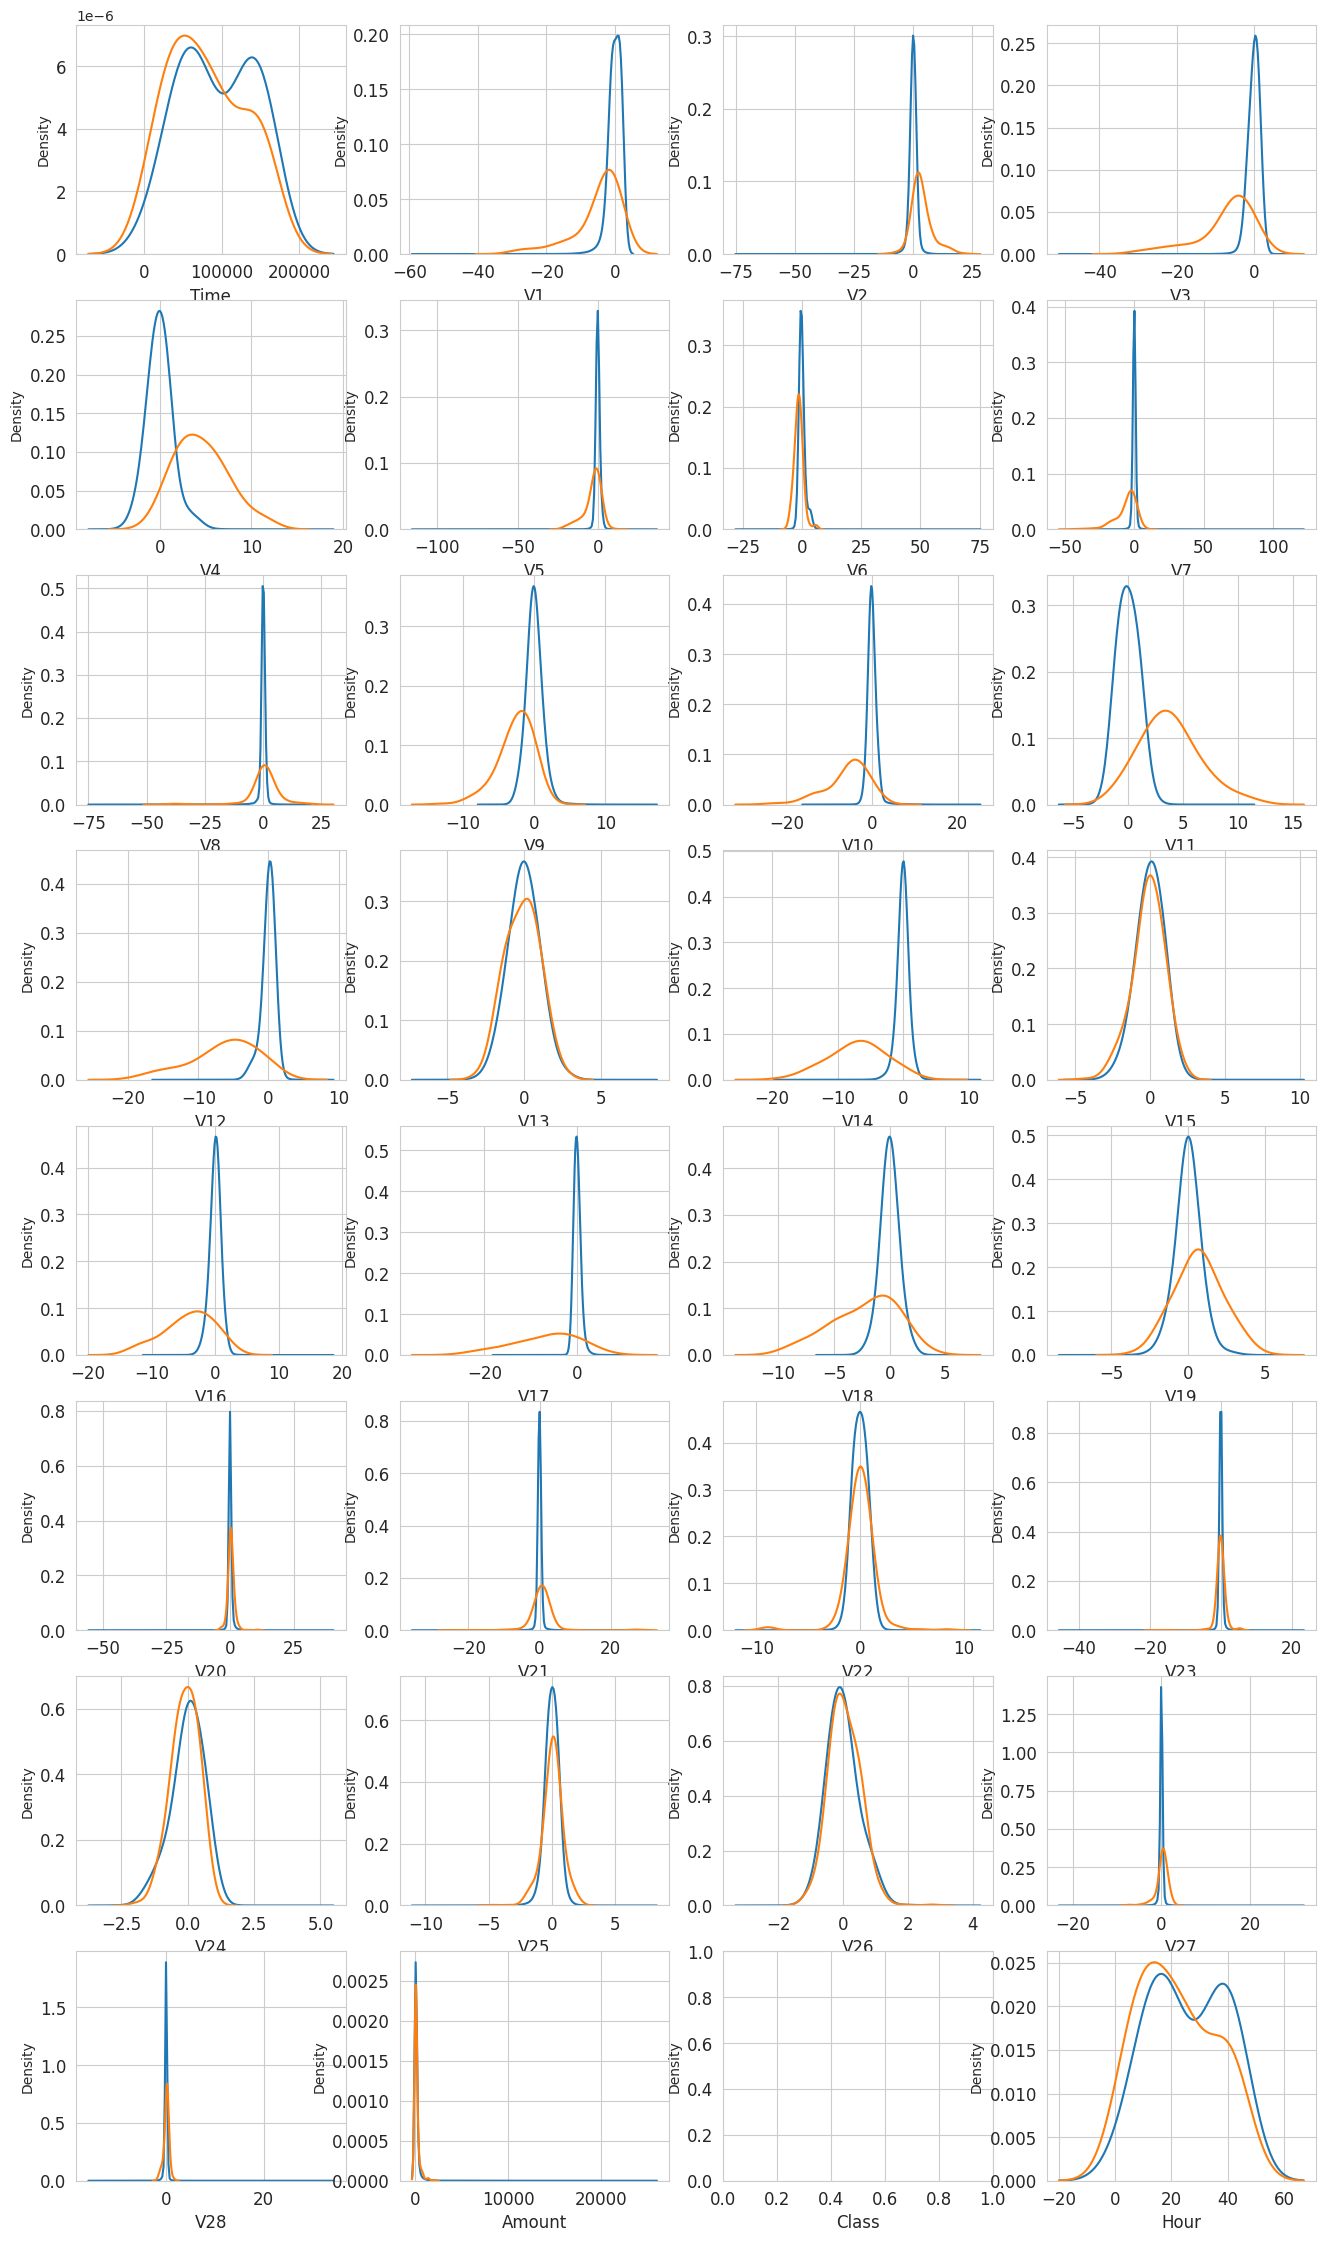

In [94]:
var = data_df.columns.values

i = 0
t0 = data_df.loc[data_df['Class'] == 0]
t1 = data_df.loc[data_df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

For some of the features we can observe a good selectivity in terms of distribution for the two values of **Class**: **V4**, **V11** have clearly separated distributions for **Class** values 0 and 1, **V12**, **V14**, **V18** are partially separated, **V1**, **V2**, **V3**, **V10** have a quite distinct profile, whilst **V25**, **V26**, **V28** have similar profiles for the two values of **Class**.  

In general, with just few exceptions (**Time** and **Amount**), the features distribution for legitimate transactions (values of **Class = 0**)  is centered around 0, sometime with a long queue at one of the extremities. In the same time, the fraudulent transactions (values of **Class = 1**) have a skewed (asymmetric) distribution.

# <a id="6">Predictive models</a>  



### Define predictors and target values

Let's define the predictor features and the target features. Categorical features, if any, are also defined. In our case, there are no categorical feature.

In [95]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

### Split data in train, test and validation set

Let's define train, validation and test sets.

In [96]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

Let's start with a RandomForrestClassifier <a href='#8'>[3]</a>   model.

## <a id="61">RandomForestClassifier</a>


### Define model parameters

Let's set the parameters for the model.

Let's run a model using the training set for training. Then, we will use the validation set for validation.

We will use as validation criterion **GINI**, which formula is **GINI = 2 * (AUC) - 1**, where **AUC** is the **Receiver Operating Characteristic - Area Under Curve (ROC-AUC)** <a href='#8'>[4]</a>.  Number of estimators is set to **100** and number of parallel jobs is set to **4**.

We start by initializing the RandomForestClassifier.

In [97]:
clf = RandomForestClassifier(n_jobs=NO_JOBS,
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

Let's train the **RandonForestClassifier** using the **train_df** data and **fit** function.

In [98]:
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

Let's now predict the **target** values for the **valid_df** data, using **predict** function.

In [99]:
preds = clf.predict(valid_df[predictors])

Let's also visualize the features importance.

### Features importance

/tmp/ipython-input-2374030792.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



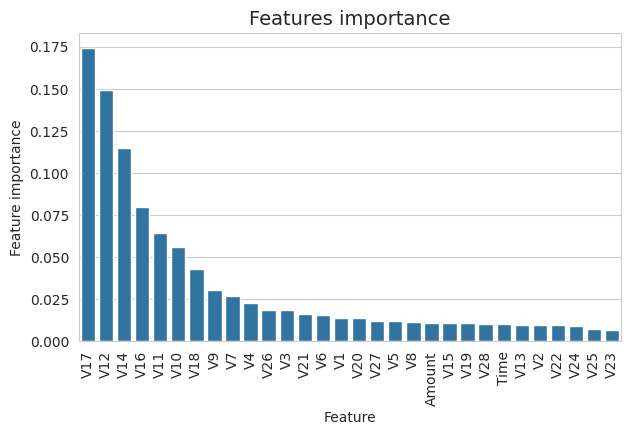

In [100]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()


The most important features are **V17**, **V12**, **V14**, **V10**, **V11**, **V16**.


### Confusion matrix

Let's show a confusion matrix for the results we obtained.

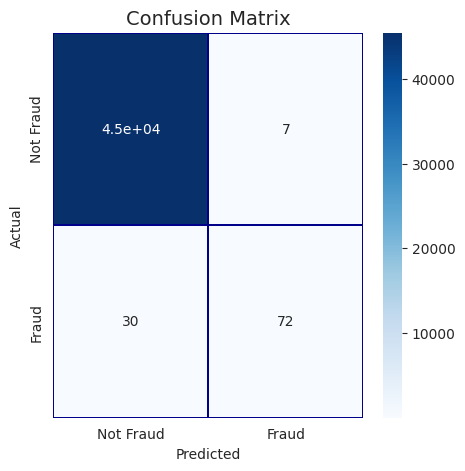

In [101]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

### Type I error and Type II error

We need to clarify that confussion matrix are not a very good tool to represent the results in the case of largely unbalanced data, because we will actually need a different metrics that accounts in the same time for the **selectivity** and **specificity** of the method we are using, so that we minimize in the same time both **Type I errors** and **Type II errors**.


**Null Hypothesis** (**H0**) - The transaction is not a fraud.  
**Alternative Hypothesis** (**H1**) - The transaction is a fraud.  

**Type I error** - You reject the null hypothesis when the null hypothesis is actually true.  
**Type II error** - You fail to reject the null hypothesis when the the alternative hypothesis is true.  

**Cost of Type I error** - You erroneously presume that the the transaction is a fraud, and a true transaction is rejected.  
**Cost of Type II error** - You erroneously presume that the transaction is not a fraud and a ffraudulent transaction is accepted.  

The following image explains what **Type I error** and **Type II error** are:    


<img src="https://i.stack.imgur.com/x1GQ1.png" width="600"/>

And this alternative image explains even better:  

<img src="https://i2.wp.com/flowingdata.com/wp-content/uploads/2014/05/Type-I-and-II-errors1.jpg" width="600"/>



Let's calculate the ROC-AUC score <a href='#8'>[4]</a>.

### Area under curve

In [102]:
roc_auc_score(valid_df[target].values, preds)

np.float64(0.8528641975628091)

The **ROC-AUC** score obtained with **RandomForrestClassifier** is **0.85**.





## <a id="62">AdaBoostClassifier</a>


AdaBoostClassifier stands for Adaptive Boosting Classifier <a href='#8'>[5]</a>.

### Prepare the model

Let's set the parameters for the model and initialize the model.

In [103]:
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

### Fit the model

Let's fit the model.

In [104]:
clf.fit(train_df[predictors], train_df[target].values)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning:

The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.



AdaBoostClassifier(algorithm='SAMME', learning_rate=0.8, n_estimators=100,
                   random_state=2018)

### Predict the target values

Let's now predict the **target** values for the **valid_df** data, using predict function.

In [105]:
preds = clf.predict(valid_df[predictors])

### Features importance

Let's see also the features importance.

/tmp/ipython-input-1428594667.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



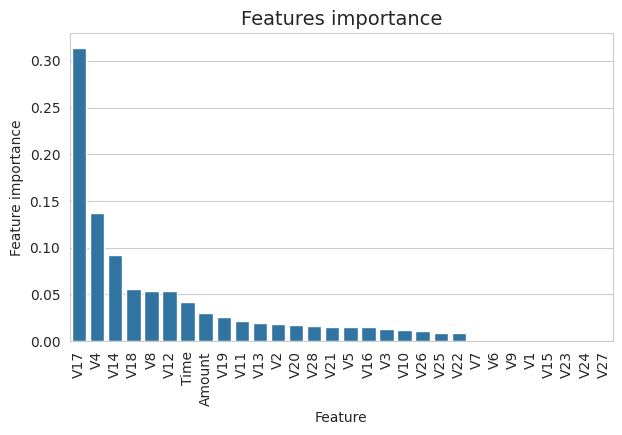

In [106]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

### Confusion matrix

Let's visualize the confusion matrix.

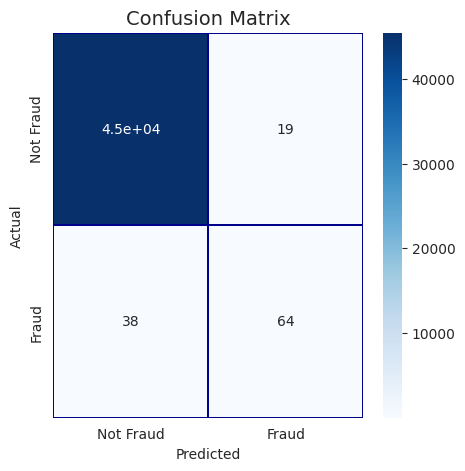

In [107]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

Let's calculate also the ROC-AUC.


### Area under curve

In [108]:
roc_auc_score(valid_df[target].values, preds)

np.float64(0.8135165474463918)

The ROC-AUC score obtained with AdaBoostClassifier is **0.83**.

## <a id="63">CatBoostClassifier</a>


CatBoostClassifier is a gradient boosting for decision trees algorithm with support for handling categorical data <a href='#8'>[6]</a>.

### Prepare the model

Let's set the parameters for the model and initialize the model.

In [109]:
clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [110]:
clf.fit(train_df[predictors], train_df[target].values,verbose=True)

0:	total: 716ms	remaining: 5m 57s
50:	total: 32.4s	remaining: 4m 44s
100:	total: 1m 4s	remaining: 4m 12s
150:	total: 1m 33s	remaining: 3m 37s
200:	total: 2m 3s	remaining: 3m 3s
250:	total: 2m 34s	remaining: 2m 33s
300:	total: 3m 4s	remaining: 2m 1s
350:	total: 3m 34s	remaining: 1m 30s
400:	total: 4m 5s	remaining: 1m
450:	total: 4m 35s	remaining: 29.9s
499:	total: 5m 4s	remaining: 0us


### Predict the target values

Let's now predict the **target** values for the **val_df** data, using predict function.

In [111]:
preds = clf.predict(valid_df[predictors])

### Features importance

Let's see also the features importance.

/tmp/ipython-input-1428594667.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



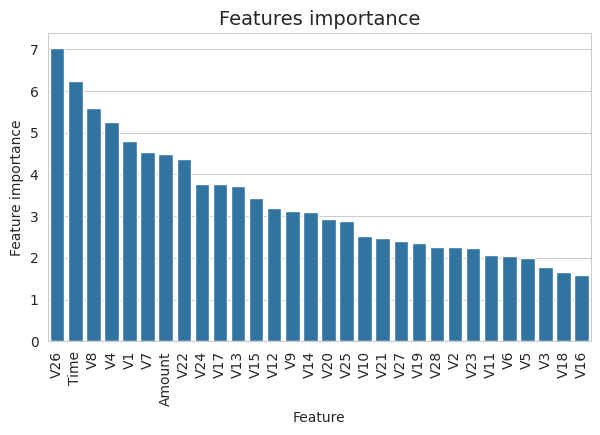

In [112]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

### Confusion matrix

Let's visualize the confusion matrix.

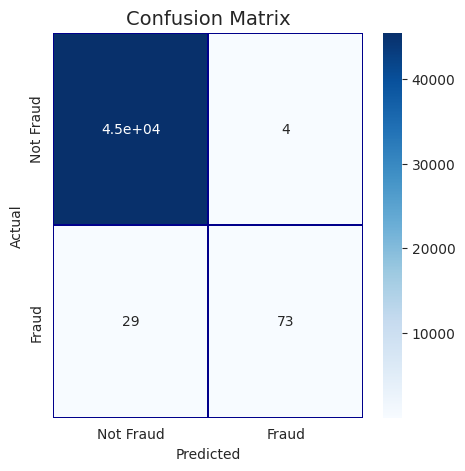

In [113]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

Let's calculate also the ROC-AUC.


### Area under curve

In [114]:
roc_auc_score(valid_df[target].values, preds)

np.float64(0.8577991493075996)

The ROC-AUC score obtained with CatBoostClassifier is **0.86**.

## <a id="63">XGBoost</a>

XGBoost is a gradient boosting algorithm <a href='#8'>[7]</a>.

Let's prepare the model.

### Prepare the model

We initialize the DMatrix objects for training and validation, starting from the datasets. We also set some of the parameters used for the model tuning.

In [115]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

### Train the model

Let's train the model.

In [116]:
model = xgb.train(params,
                dtrain,
                MAX_ROUNDS,
                watchlist,
                early_stopping_rounds=EARLY_STOP,
                maximize=True,
                verbose_eval=VERBOSE_EVAL)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:726: FutureWarning:

Pass `evals` as keyword args.

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning:

[20:19:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "silent" } are not used.




[0]	train-auc:0.93758	valid-auc:0.88823
[50]	train-auc:0.98434	valid-auc:0.97558
[100]	train-auc:0.98999	valid-auc:0.97847
[150]	train-auc:0.99261	valid-auc:0.97674
[160]	train-auc:0.99304	valid-auc:0.97720


The best validation score (ROC-AUC) was **0.984**, for round **241**.

### Plot variable importance

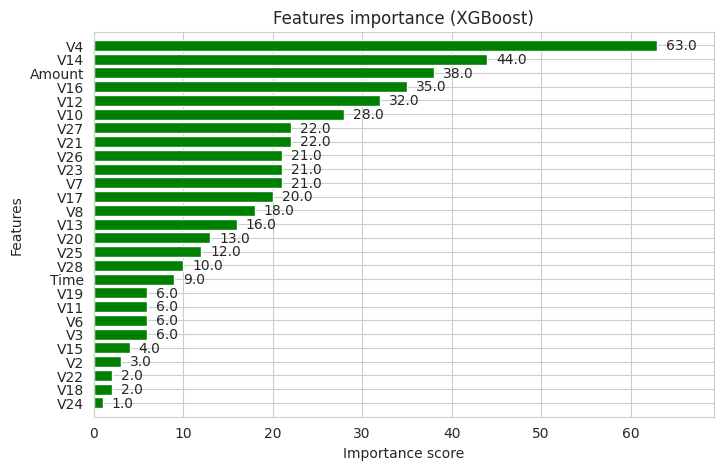

In [117]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green")
plt.show()

### Predict test set


We used the train and validation sets for training and validation. We will use the trained model now to predict the target value for the test set.

In [118]:
preds = model.predict(dtest)

### Area under curve

Let's calculate ROC-AUC.

In [119]:
roc_auc_score(test_df[target].values, preds)

np.float64(0.9771017551264465)

The AUC score for the prediction of fresh data (test set) is **0.974**.

## <a id="64">LightGBM</a>


Let's continue with another gradient boosting algorithm, LightGBM <a href='#8'>[8]</a> <a href='#8'>[9]</a>.


### Define model parameters

Let's set the parameters for the model. We will use these parameters only for the first lgb model.

In [120]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # because training data is extremely unbalanced
         }

### Prepare the model

Let's prepare the model, creating the **Dataset**s data structures from the train and validation sets.

In [121]:
dtrain = lgb.Dataset(train_df[predictors].values,
                     label=train_df[target].values,
                     feature_name=predictors)

dvalid = lgb.Dataset(valid_df[predictors].values,
                     label=valid_df[target].values,
                     feature_name=predictors)

### Run the model

Let's run the model, using the **train** function.

In [122]:

import lightgbm as lgb

evals_results = {}

model = lgb.train(
    params,                   # make sure params includes a metric, e.g. 'metric': 'auc'
    dtrain,
    valid_sets=[dtrain, dvalid],
    valid_names=['train', 'valid'],
    num_boost_round=MAX_ROUNDS,
    feval=None,
    callbacks=[
        lgb.early_stopping(stopping_rounds=2*EARLY_STOP),            # <-- replaces early_stopping_rounds
        lgb.log_evaluation(period=VERBOSE_EVAL if isinstance(VERBOSE_EVAL, int) else 50),  # <-- replaces verbose_eval
        lgb.record_evaluation(evals_results)                         # <-- replaces evals_result=
    ],
)


print("Best iteration:", model.best_iteration)
print("Valid AUC at best iter:", model.best_score["valid"]["auc"])
print("Train AUC at best iter:", model.best_score["train"]["auc"])


Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.997909	valid's auc: 0.952288
[100]	train's auc: 0.999032	valid's auc: 0.945553
Early stopping, best iteration is:
[29]	train's auc: 0.996594	valid's auc: 0.957864
Best iteration: 29
Valid AUC at best iter: 0.9578641824689055
Train AUC at best iter: 0.9965937982345743


Best validation score  was obtained for round **85**, for which

*   List item
*   List item

**AUC ~= 0.974**. **(0.957)**

Let's plot variable importance.

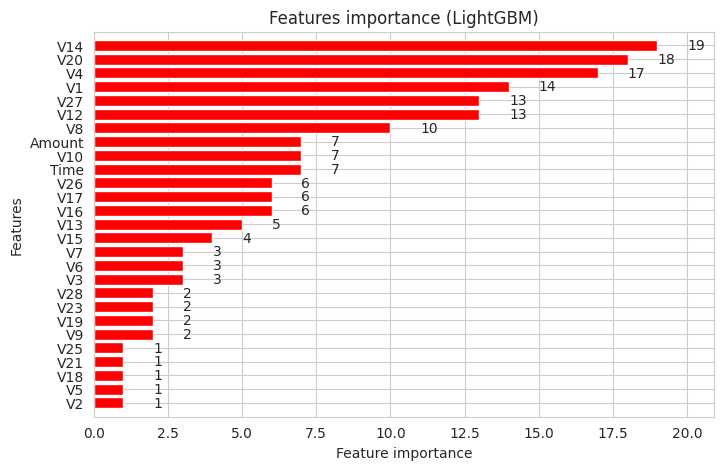

In [123]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model, height=0.8, title="Features importance (LightGBM)", ax=ax,color="red")
plt.show()

Let's predict now the target for the test data.

### Predict test data

In [124]:
preds = model.predict(test_df[predictors])

### Area under curve

Let's calculate the ROC-AUC score for the prediction.

In [125]:
roc_auc_score(test_df[target].values, preds)

np.float64(0.9473337202349548)

*The* ROC-AUC score obtained for the test set is **0.946**.

### Training and validation using cross-validation

Let's use now cross-validation. We will use cross-validation (KFolds) with 5 folds. Data is divided in 5 folds and, by rotation, we are training using 4 folds (n-1) and validate using the 5th (nth) fold.

Test set is calculated as an average of the predictions

In [126]:
# ====== Config ======
NUMBER_KFOLDS = 5
RANDOM_STATE = 42
EARLY_STOP = 100           # patience
VERBOSE_EVAL = 50          # log every N iters; set to 0 to silence

# ====== Imports ======
import gc
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import lightgbm as lgb

# ====== Optional: handle categorical predictors ======
# If you have object/category columns, convert to 'category' dtype
cat_cols = [c for c in predictors if str(train_df[c].dtype) in ("object", "category")]
for c in cat_cols:
    train_df[c] = train_df[c].astype("category")
    if c in test_df.columns:
        test_df[c] = test_df[c].astype("category")

# ====== KFold setup ======
kf = StratifiedKFold(n_splits=NUMBER_KFOLDS, random_state=RANDOM_STATE, shuffle=True)

oof_preds = np.zeros(train_df.shape[0], dtype=float)
test_preds = np.zeros(test_df.shape[0], dtype=float)
feature_importance_df = pd.DataFrame()

# — before the CV loop —
# sanity-check your predictors exist
missing = [c for c in predictors if c not in train_df.columns]
if missing:
    raise KeyError(f"These predictors are not in train_df.columns: {missing}")

# ensure target exists and is not in predictors
assert target in train_df.columns, f"target '{target}' not found"
predictors = [c for c in predictors if c != target]

# — inside the loop —
for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df[predictors], train_df[target]), start=1):
    # use .iloc for row positions, then select columns by name
    train_x = train_df.iloc[train_idx][predictors]
    train_y = train_df.iloc[train_idx][target]
    valid_x = train_df.iloc[valid_idx][predictors]
    valid_y = train_df.iloc[valid_idx][target]


    # Model (params tuned to avoid "no further splits" issues)
    model = LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.01,
        objective='binary',
        boosting_type='gbdt',

        # allow splitting
        num_leaves=128,
        max_depth=-1,
        min_child_samples=20,
        min_child_weight=1.0,
        min_split_gain=0.0,

        # binning
        max_bin=255,
        subsample_for_bin=200000,

        # sampling & regularization
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.0,
        reg_lambda=0.0,

        # imbalance handling (alternative: is_unbalance=True)
        class_weight='balanced',
        # pass categorical_feature via fit if you have any
    )

    callbacks = [
        lgb.early_stopping(stopping_rounds=EARLY_STOP),
        lgb.log_evaluation(period=int(VERBOSE_EVAL) if int(VERBOSE_EVAL) > 0 else 0),
    ]

    model.fit(
        train_x, train_y,
        eval_set=[(train_x, train_y), (valid_x, valid_y)],
        eval_metric='auc',
        callbacks=callbacks,
        categorical_feature=cat_cols if len(cat_cols) else 'auto'
    )

    # Use best_iteration_ for prediction
    best_iter = getattr(model, "best_iteration_", None)
    oof_preds[valid_idx] = model.predict_proba(valid_x, num_iteration=best_iter)[:, 1]
    test_preds += model.predict_proba(test_df[predictors], num_iteration=best_iter)[:, 1] / kf.n_splits

    # Fold AUC
    fold_auc = roc_auc_score(valid_y, oof_preds[valid_idx])
    print(f"Fold {fold:02d} AUC: {fold_auc:.6f}")

    # Feature importances
    fold_importance = pd.DataFrame({
        "feature": predictors,
        "importance": model.feature_importances_,
        "fold": fold
    })
    feature_importance_df = pd.concat([feature_importance_df, fold_importance], axis=0, ignore_index=True)

    del model, train_x, train_y, valid_x, valid_y
    gc.collect()

# ====== Overall AUC ======
full_auc = roc_auc_score(train_df[target], oof_preds)
print(f"\nFull OF AUC: {full_auc:.6f}")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.999965	training's binary_logloss: 0.36271	valid_1's auc: 0.964479	valid_1's binary_logloss: 0.363228
[100]	training's auc: 0.999966	training's binary_logloss: 0.205112	valid_1's auc: 0.962933	valid_1's binary_logloss: 0.205937
Early stopping, best iteration is:
[43]	training's auc: 0.999965	training's binary_logloss: 0.394663	valid_1's auc: 0.967456	valid_1's binary_logloss: 0.395153
Fold 01 AUC: 0.967456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.99996	training's binary_logloss: 0.363031	valid_1's auc: 0.938014	valid_1's binary_logloss: 0.363328
[100]	training's auc: 0.999963	training's binary_logloss: 0.205401	valid_1's auc: 0.979041	valid_1's binary_logloss: 0.205908
[150]	training's auc: 0.999962	training's bi

In [127]:

# ====== summarize importances across folds ======
feat_imp_mean = (feature_importance_df
                 .groupby("feature")["importance"]
                 .mean()
                 .sort_values(ascending=False))
print("\nTop 20 features by mean importance:")
print(feat_imp_mean.head(20))


Top 20 features by mean importance:
feature
V4        831.8
V12       735.4
V14       650.4
V17       627.8
V11       594.6
V16       572.6
V1        511.4
V13       494.8
Amount    486.4
V10       471.8
V20       471.0
V26       448.2
Time      422.2
V19       421.8
V15       406.0
V21       395.4
V23       392.8
V8        388.0
V3        380.4
V7        368.2
Name: importance, dtype: float64


The AUC score for the prediction from the test data was 0.93.

We prepare the test prediction, from the averaged predictions for test over the 5 folds.

In [128]:
pred = test_preds

# <a id="7">Conclusions</a>

We investigated the data, checking for data unbalancing, visualizing the features and understanding the relationship between different features.
We then investigated two predictive models. The data was split in 3 parts, a train set, a validation set and a test set. For the first three models, we only used the train and test set.  

We started with **RandomForrestClassifier**, for which we obtained an AUC scode of **0.85** when predicting the target for the test set.  

We followed with an **AdaBoostClassifier** model, with lower AUC score (**0.83**) for prediction of the test set target values.    

We then followed with an **CatBoostClassifier**, with the AUC score after training 500 iterations **0.86**.    

We then experimented with a **XGBoost** model. In this case, se used the validation set for validation of the training model.  The best validation score obtained was   **0.984**. Then we used the model with the best training step, to predict target value from the test data; the AUC score obtained was **0.974**.

We then presented the data to a **LightGBM** model. We used both train-validation split and cross-validation to evaluate the model effectiveness to predict 'Class' value, i.e. detecting if a transaction was fraudulent. With the first method we obtained values of AUC for the validation set around **0.974** **(0.932)**. For the test set, the score obtained was **0.946**.   
With the cross-validation, we obtained an AUC score for the test prediction of  **0.93**.

# <a id="8">References</a>

[1] Credit Card Fraud Detection Database, Anonymized credit card transactions labeled as fraudulent or genuine, https://www.kaggle.com/mlg-ulb/creditcardfraud  
[2] Principal Component Analysis, Wikipedia Page, https://en.wikipedia.org/wiki/Principal_component_analysis  
[3] RandomForrestClassifier, http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html  
[4] ROC-AUC characteristic, https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve   
[5] AdaBoostClassifier, http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html  
[6] CatBoostClassifier, https://tech.yandex.com/catboost/doc/dg/concepts/python-reference_catboostclassifier-docpage/  
[7] XGBoost Python API Reference, http://xgboost.readthedocs.io/en/latest/python/python_api.html  
[8] LightGBM Python implementation, https://github.com/Microsoft/LightGBM/tree/master/python-package  
[9] LightGBM algorithm, https://www.microsoft.com/en-us/research/wp-content/uploads/2017/11/lightgbm.pdf   

